# COMP SCI 760 - HomeWork 2
## Submitted by - Suyash Raj (ID - 90860122844)
---

# 1) Simplified Decision Tree

In [45]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [2]:
class SimplDecisionTreeNode:
    
    def __init__(self, threshold = 0, dimension = 0, left = None, right = None, label = -1):
        self.threshold = threshold
        self.dimension = dimension
        self.left = left
        self.right = right
        self.label = label

    def __str__(self):
        if self.label == -1:
            return f'Tree Node: (threshold: {self.threshold}, dimension: {self.dimension})'
        else:
            return f'Tree Leaf: (label: {self.label})'

    def is_leaf_node(self):
        return (self.label != -1)

    def get_nodes_count(self):
        node_count = 1
        if self.left != None:
            node_count += self.left.get_nodes_count()
        if self.right != None:
            node_count += self.right.get_nodes_count()

        return node_count

    def classify(self, x):
        if self.label != -1:
            return self.label
        else:
            if x[self.dimension] >= self.threshold:
                return self.left.classify(x)
            else:
                return self.right.classify(x)

In [3]:
def calculateLabelsEntropy(count_pos = 0, count_neg = 0):
    e_pos = 0
    e_neg = 0

    if count_pos != 0:
        pos_ratio = count_pos / (count_pos + count_neg)
        e_pos = -1 * pos_ratio * math.log2(pos_ratio)

    if count_neg != 0:
        neg_ratio = count_neg / (count_pos + count_neg)
        e_neg = -1 * neg_ratio * math.log2(neg_ratio)

    return e_pos + e_neg

In [4]:
def calculateSplitEntropy(count_left = 0, count_right = 0):
    e_left = 0
    e_right = 0

    if count_left != 0:
        left_ratio = count_left / (count_left + count_right)
        e_left = -1 * left_ratio * math.log2(left_ratio)

    if count_right != 0:
        right_ratio = count_right / (count_left + count_right)
        e_right = -1 * right_ratio * math.log2(right_ratio)

    return e_left + e_right

In [5]:
def calculateLabelSplitEntropy(count_pos_left = 0, count_neg_left = 0, count_pos_right = 0, count_neg_right = 0):
    count_left = count_pos_left + count_neg_left
    count_right = count_pos_right + count_neg_right
    
    e_left = 0
    e_right = 0

    if count_left != 0:
        left_entropy = calculateLabelsEntropy(count_pos_left, count_neg_left)
        e_left = (count_left / (count_left + count_right)) * left_entropy

    if count_right != 0:
        right_entropy = calculateLabelsEntropy(count_pos_right, count_neg_right)
        e_right = (count_right / (count_left + count_right)) * right_entropy

    return e_left + e_right

In [6]:
def calculateInfoGain(count_pos_left, count_neg_left, count_pos_right, count_neg_right):
    count_pos = count_pos_left + count_pos_right
    count_neg = count_neg_left + count_neg_right

    h_y = calculateLabelsEntropy(count_pos, count_neg)
    h_ys = calculateLabelSplitEntropy(count_pos_left, count_neg_left, count_pos_right, count_neg_right)
    infogain = h_y - h_ys
    
    return infogain

In [71]:
def calculateGainRatio(count_pos_left, count_neg_left, count_pos_right, count_neg_right):
    infogain = calculateInfoGain(count_pos_left, count_neg_left, count_pos_right, count_neg_right)
    
    if infogain == 0:
        return infogain
    else:
        count_right = count_pos_right + count_neg_right
        count_left = count_pos_left + count_neg_left

        h_s = calculateSplitEntropy(count_left, count_right)
        
        if h_s == 0:
            return float('inf')

        return infogain / h_s

In [54]:
def determineCandidateSplits(x_train, y_train, verbose = False):
    candidate_splits = {}
    n = len(x_train)

    for j in range(2):
        for i in range(n):
            c = x_train[i][j]
            count_pos_left = sum([x_train[idx][j] >= c for idx in range(n) if y_train[idx][0] == 1])
            count_neg_left = sum([x_train[idx][j] >= c for idx in range(n) if y_train[idx][0] == 0])
            count_pos_right = sum([x_train[idx][j] < c for idx in range(n) if y_train[idx][0] == 1])
            count_neg_right = sum([x_train[idx][j] < c for idx in range(n) if y_train[idx][0] == 0])
            candidate_splits[(j, c)] = min(candidate_splits.get((j, c), float('inf')), calculateGainRatio(count_pos_left, count_neg_left, count_pos_right, count_neg_right))

    return candidate_splits

In [10]:
def isStoppingConditionMet(candidate_splits = {}):
    if len(candidate_splits) == 0:
        return True
    
    all_gain_ratio_zero = max(candidate_splits.values()) == 0
    any_split_entropy_zero = max(candidate_splits.values()) == float('inf')

    if all_gain_ratio_zero == True or any_split_entropy_zero == True:
        return True

    return False

In [11]:
def getMajorityClass(labels=[]):
    count_pos = 0
    count_neg = 0

    for label in labels:
        if label[0] == 0:
            count_neg += 1
        else:
            count_pos += 1

    if count_pos >= count_neg:
        return 1
    else:
        return 0

In [12]:
def findBestSplit(candidate_splits):
    best_split = max(candidate_splits, key = candidate_splits.get)
    best_split_gainratio = candidate_splits[best_split]

    return best_split, best_split_gainratio

In [13]:
def makeTree(x_train, y_train):
    #print("makeTree called for : ", x_train, y_train)
    candidate_splits = determineCandidateSplits(x_train, y_train)
    treeNode = None

    if isStoppingConditionMet(candidate_splits):
        #print("Stopping condition met")
        label = getMajorityClass(y_train)
        treeNode = SimplDecisionTreeNode(label=label)
    else:
        best_split, _ = findBestSplit(candidate_splits)
        x_train_left = []
        x_train_right = []
        y_train_left = []
        y_train_right = []
        j = best_split[0]
        c = best_split[1]
        #print("j, c for best split: ", j, c)

        for i in range(len(x_train)):
            if x_train[i][j] >= c:
                x_train_left.append(x_train[i])
                y_train_left.append(y_train[i])
            else:
                x_train_right.append(x_train[i])
                y_train_right.append(y_train[i])

        #print("left", x_train_left, y_train_left)
        #print("right", x_train_right, y_train_right)

        treeNode = SimplDecisionTreeNode(threshold=c, dimension=j, left=makeTree(x_train_left, y_train_left), right = makeTree(x_train_right, y_train_right))

    return treeNode

# 2) Questions

In [21]:
def readTrainDataFromFile(file):
    df = pd.read_csv(file, sep=' ', header=None)
    x_df = df.loc[:, :1]
    y_df = df.loc[:, 2:]
    x_train, y_train = x_df.values.tolist(), y_df.values.tolist()

    return x_train, y_train

In [29]:
def visualizeTree(node, indent = 0, label = "Root"):
    print(' '*indent, label, str(node))
    
    indent += 1

    if node.left != None:
        visualizeTree(node.left, indent = indent, label="Left")
    if node.right != None:
        visualizeTree(node.right, indent = indent, label="Right")

In [30]:
def printLogicRules(node, indent = 0):
    
    if node.is_leaf_node():
        print(' '*indent, f'Predict {node.label}.')
        return

    j = node.dimension
    c = node.threshold

    if node.left != None:
        print(' '*indent, f'If x[{j}] >= {c}: ')
        printLogicRules(node.left, indent = indent+1)
    if node.right != None:
        print(' '*indent, f'Else (if x[{j}] < {c}): ')
        printLogicRules(node.right, indent = indent+1)

### 2.2) Our algorithm is greedy

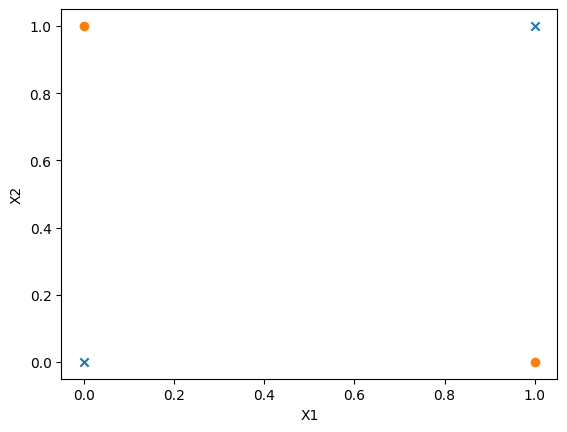

In [36]:
## s2q2
## Training data points
x = [[0, 0], [0, 1], [1, 0], [1, 1]]
y = [[0], [1], [1], [0]]

x_1 = [x_i[0] for x_i in x]
x_2 = [x_i[1] for x_i in x]

lab_neg_idx = [i for i in range(len(y)) if y[i][0]==0]
lab_pos_idx = [i for i in range(len(y)) if y[i][0]==1]

x_1_neg = [x_1[i] for i in lab_neg_idx]
x_1_pos = [x_1[i] for i in lab_pos_idx]
x_2_neg = [x_2[i] for i in lab_neg_idx]
x_2_pos = [x_2[i] for i in lab_pos_idx]

plt.scatter(x_1_neg, x_2_neg, marker='x')
plt.scatter(x_1_pos, x_2_pos, marker='o')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

### 2.3) Information Gain Ratio Exercise

In [67]:
## s2_q3
x_train, y_train = readTrainDataFromFile("data\Druns.txt")
candidate_splits = determineCandidateSplits(x_train, y_train)

print("Candidate Splits are: ")
for split, gainratio in candidate_splits.items():
    print(f"[ j = {split[0]}; c = {split[1]}; GainRatio = {gainratio} ]")

Candidate Splits are: 
[ j = 0; c = 0.1; GainRatio = 0.10051807676021852 ]
[ j = 0; c = 0.0; GainRatio = 0.0 ]
[ j = 1; c = -2.0; GainRatio = 0.0 ]
[ j = 1; c = -1.0; GainRatio = 0.10051807676021852 ]
[ j = 1; c = 0.0; GainRatio = 0.055953759631263686 ]
[ j = 1; c = 1.0; GainRatio = 0.005780042205152451 ]
[ j = 1; c = 2.0; GainRatio = 0.0011443495172768668 ]
[ j = 1; c = 3.0; GainRatio = 0.016411136842102245 ]
[ j = 1; c = 4.0; GainRatio = 0.04974906418177866 ]
[ j = 1; c = 5.0; GainRatio = 0.1112402958633981 ]
[ j = 1; c = 6.0; GainRatio = 0.2360996061436081 ]
[ j = 1; c = 7.0; GainRatio = 0.055953759631263686 ]
[ j = 1; c = 8.0; GainRatio = 0.43015691613098095 ]


In [68]:
tree = makeTree(x_train, y_train)
visualizeTree(tree)

 Root Tree Node: (threshold: 8.0, dimension: 1)
  Left Tree Leaf: (label: 1)
  Right Tree Node: (threshold: 0.0, dimension: 1)
   Left Tree Node: (threshold: 6.0, dimension: 1)
    Left Tree Node: (threshold: 7.0, dimension: 1)
     Left Tree Leaf: (label: 0)
     Right Tree Leaf: (label: 1)
    Right Tree Leaf: (label: 0)
   Right Tree Node: (threshold: 0.1, dimension: 0)
    Left Tree Leaf: (label: 0)
    Right Tree Leaf: (label: 1)


### 2.4) The king of interpretability

In [79]:
## s2q4
x_train, y_train = readTrainDataFromFile("data\D3leaves.txt")

In [80]:
tree = makeTree(x_train, y_train)

In [81]:
## Show the tree
visualizeTree(tree)

 Root Tree Node: (threshold: 10, dimension: 0)
  Left Tree Leaf: (label: 1)
  Right Tree Node: (threshold: 3, dimension: 1)
   Left Tree Leaf: (label: 1)
   Right Tree Leaf: (label: 0)


In [82]:
## Show the logic rules for the tree
print("The LOGIC RULES for the above tree are:\n")
printLogicRules(tree)

The LOGIC RULES for the above tree are:

 If x[0] >= 10: 
  Predict 1.
 Else (if x[0] < 10): 
  If x[1] >= 3: 
   Predict 1.
  Else (if x[1] < 3): 
   Predict 0.


### 2.5) Or is it

In [86]:
## s2q5
## for D1.txt
x_train, y_train = readTrainDataFromFile("data\D1.txt")
tree = makeTree(x_train, y_train)
visualizeTree(tree)

 Root Tree Node: (threshold: 0.201829, dimension: 1)
  Left Tree Leaf: (label: 1)
  Right Tree Leaf: (label: 0)


In [87]:
printLogicRules(tree)

 If x[1] >= 0.201829: 
  Predict 1.
 Else (if x[1] < 0.201829): 
  Predict 0.


#### Interpretation

In the **D1.txt** dataset, the resulting tree has only one root node (decision-making node) and two leaf nodes. Therefore, it becomes very simple to interpret the decision boundary. The same also becomes clear from the logic rules visualized above. If $x_1$ (assuming index starting at $0$) is greater than or equal to $0.201829$, then predict label $1$, else predict label $0$.

In [88]:
## for D2.txt
x_train, y_train = readTrainDataFromFile("data\D2.txt")
tree = makeTree(x_train, y_train)
visualizeTree(tree)

 Root Tree Node: (threshold: 0.533076, dimension: 0)
  Left Tree Node: (threshold: 0.228007, dimension: 1)
   Left Tree Node: (threshold: 0.424906, dimension: 1)
    Left Tree Leaf: (label: 1)
    Right Tree Node: (threshold: 0.708127, dimension: 0)
     Left Tree Leaf: (label: 1)
     Right Tree Node: (threshold: 0.32625, dimension: 1)
      Left Tree Node: (threshold: 0.595471, dimension: 0)
       Left Tree Node: (threshold: 0.646007, dimension: 0)
        Left Tree Leaf: (label: 1)
        Right Tree Node: (threshold: 0.403494, dimension: 1)
         Left Tree Leaf: (label: 1)
         Right Tree Leaf: (label: 0)
       Right Tree Leaf: (label: 0)
      Right Tree Leaf: (label: 0)
   Right Tree Node: (threshold: 0.887224, dimension: 0)
    Left Tree Node: (threshold: 0.037708, dimension: 1)
     Left Tree Node: (threshold: 0.082895, dimension: 1)
      Left Tree Leaf: (label: 1)
      Right Tree Node: (threshold: 0.960783, dimension: 0)
       Left Tree Leaf: (label: 1)
       Righ

In [89]:
printLogicRules(tree)

 If x[0] >= 0.533076: 
  If x[1] >= 0.228007: 
   If x[1] >= 0.424906: 
    Predict 1.
   Else (if x[1] < 0.424906): 
    If x[0] >= 0.708127: 
     Predict 1.
    Else (if x[0] < 0.708127): 
     If x[1] >= 0.32625: 
      If x[0] >= 0.595471: 
       If x[0] >= 0.646007: 
        Predict 1.
       Else (if x[0] < 0.646007): 
        If x[1] >= 0.403494: 
         Predict 1.
        Else (if x[1] < 0.403494): 
         Predict 0.
      Else (if x[0] < 0.595471): 
       Predict 0.
     Else (if x[1] < 0.32625): 
      Predict 0.
  Else (if x[1] < 0.228007): 
   If x[0] >= 0.887224: 
    If x[1] >= 0.037708: 
     If x[1] >= 0.082895: 
      Predict 1.
     Else (if x[1] < 0.082895): 
      If x[0] >= 0.960783: 
       Predict 1.
      Else (if x[0] < 0.960783): 
       Predict 0.
    Else (if x[1] < 0.037708): 
     Predict 0.
   Else (if x[0] < 0.887224): 
    If x[0] >= 0.850316: 
     If x[1] >= 0.169053: 
      Predict 1.
     Else (if x[1] < 0.169053): 
      Predict 0.
    Else 

#### Interpretation

The complex tree shown above is not very open to human interpretation. This is also demonstrated by the complex set of logic rules shown above.

## 2.6) Hypothesis space

In [92]:
def addTreeToPlot(node, plt):
    if node.is_leaf_node() == False:
        if node.dimension == 0:
            plt.axvline(node.threshold, color='r')
        else:
            plt.axhline(node.threshold, color='r')

    if node.left != None:
        addTreeToPlot(node.left, plt)
        
    if node.right != None:
        addTreeToPlot(node.right, plt)

### For D1.txt

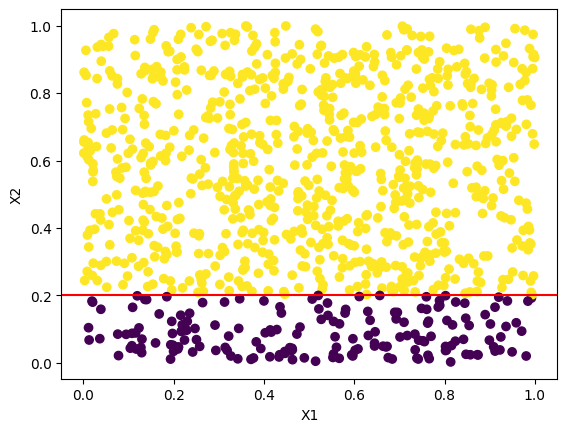

In [94]:
x_train, y_train = readTrainDataFromFile("data\D1.txt")
tree = makeTree(x_train, y_train)

x = np.array(x_train)
y = np.array(y_train)
plt.scatter(x[:, :1], x[:, 1:2], c=y, label=y)

addTreeToPlot(tree, plt)

plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

### For D2.txt

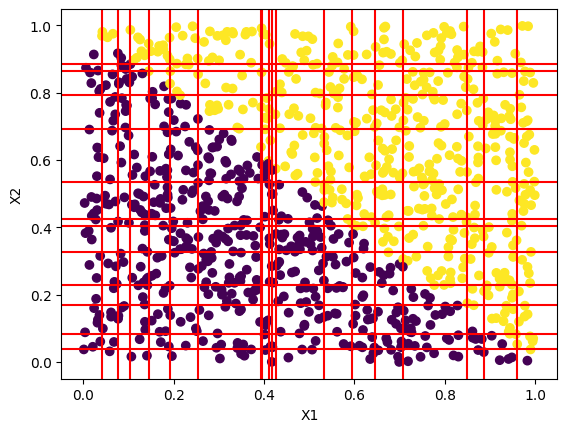

In [96]:
x_train, y_train = readTrainDataFromFile("data\D2.txt")
tree = makeTree(x_train, y_train)

x = np.array(x_train)
y = np.array(y_train)
plt.scatter(x[:, :1], x[:, 1:2], c=y, label=y)

addTreeToPlot(tree, plt)

plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

### Interpretation
The decision boundary for D1 is simple (and so is the tree) because the points are split along the horizontal axis(in this case) and so it's easy to introduce a split like $x_2 \geq c$ which can easily split the data points into two.

The data in D1 however, splits along a diagonal line(neither horizontal nor vertical), which cannot be represented by any set of simple decision boundaries of the form $x_j \geq c$. Therefore, in an attempt to fit the training points, our algorithm keeps drawing vertical and horizontal boundaries until it can.

## 2.7) Learning curve

In [100]:
## s2q7
x, y = readTrainDataFromFile("data\Dbig.txt")

indices = torch.randperm(10000).tolist()

## Permute the data
x_temp = [x[i] for i in indices]
y_temp = [y[i] for i in indices]

x_train, x_test = x_temp[:8192], x_temp[8192:]
y_train, y_test = y_temp[:8192], y_temp[8192:]

print("Training set feature length: ", len(x_train))
print("Training set label length: ", len(y_train))
print("Test set feature length: ", len(x_test))
print("Test set label length: ", len(y_test))

Training set feature length:  8192
Training set label length:  8192
Test set feature length:  1808
Test set label length:  1808


In [101]:
def calculateTestError(tree, x_test, y_test):
    n = len(y_test)
    misclass_count = 0
    for i in range(n):
        y_hat = tree.classify(x_test[i])
        if y_hat != y_test[i][0]:
            misclass_count += 1
    return misclass_count/n

In [109]:
# Generate Training Sets

x_train_sets = []
y_train_sets = []

for n in [32, 128, 512, 2048, 8192]:
    x_t = x_train[:n]
    y_t = y_train[:n]
    x_train_sets.append(x_t)
    y_train_sets.append(y_t)

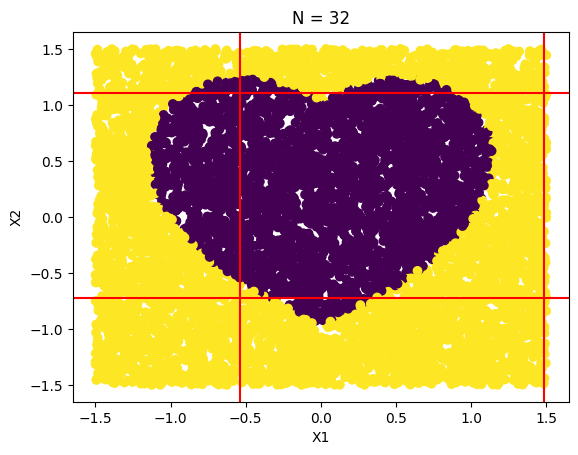

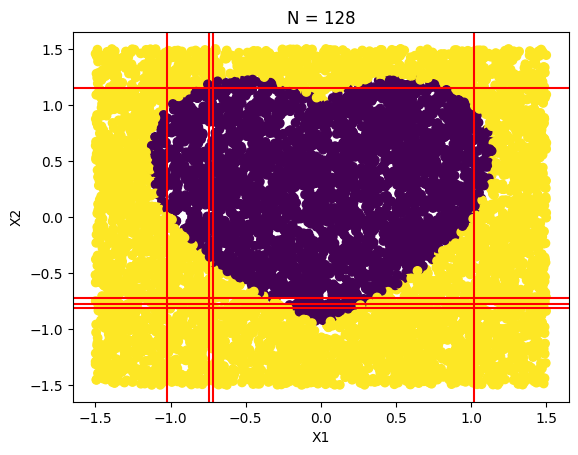

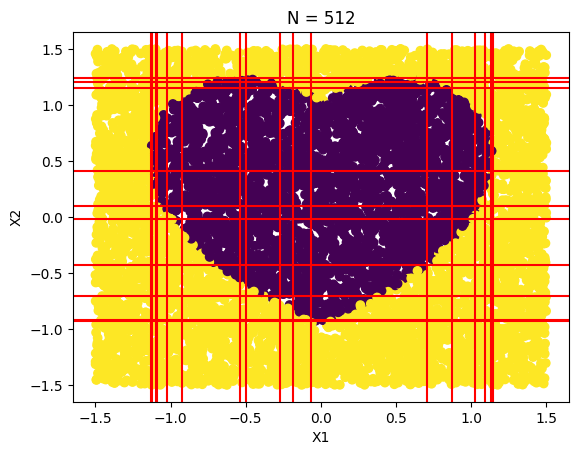

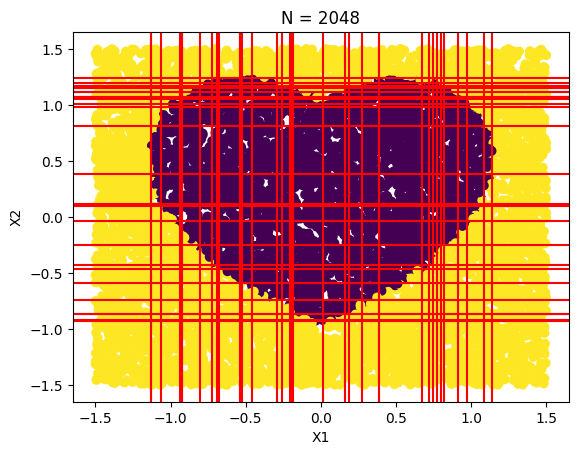

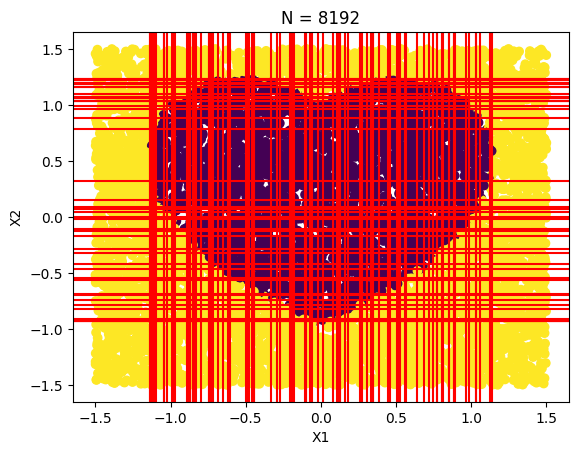

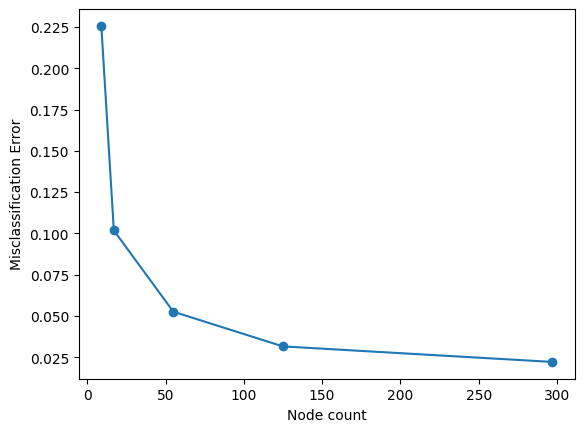

,N,Node Count,Error
0,9,32,0.225664
1,17,128,0.101770
2,55,512,0.052544
3,125,2048,0.031527
4,297,8192,0.022124


In [117]:
n_list, node_count_list, error_list = [], [], []

for x_t, y_t in zip(x_train_sets, y_train_sets):
    tree = makeTree(x_t, y_t)
    error = calculateTestError(tree, x_test, y_test)
    node_count = tree.get_nodes_count()
    
    node_count_list.append(node_count)
    n_list.append(len(y_t))
    error_list.append(error)

    ## Plot the tree
    plt.figure()
    plt.scatter((np.array(x_train))[:, :1], (np.array(x_train))[:, 1:2], c = np.array(y_train), label = y_train)
    addTreeToPlot(tree, plt)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("N = " + str(len(y_t)))
    plt.show()

plt.figure()
plt.plot(n_list, error_list, marker='o')
plt.xlabel("Node count")
plt.ylabel("Misclassification Error")
plt.show()

## Print the metrics from above
metrics = pd.DataFrame({"N": n_list, "Node Count": node_count_list, "Error": error_list})
metrics

# 3) sklearn

In [118]:
## s3
from sklearn import tree as Tree

def calculateErrorRate(y_hat, y_test):
    n = len(y_test)
    count = 0
    for i in range(n):
        if y_hat[i] != y_test[i][0]:
            count += 1

    return count/n

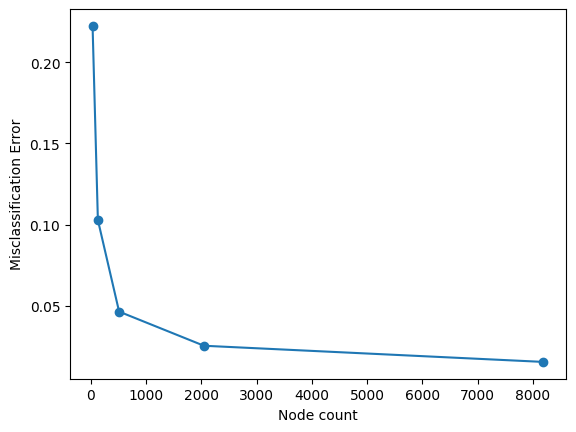

,N,Node Count,Error
0,32,9,0.222345
1,128,17,0.102876
2,512,51,0.046460
3,2048,109,0.025442
4,8192,265,0.015487


In [119]:
n_list, node_count_list, error_list = [], [], []

for x_t, y_t in zip(x_train_sets, y_train_sets):
    clf = Tree.DecisionTreeClassifier()
    clf.fit(x_t, y_t)

    node_count = clf.tree_.node_count
    error = calculateErrorRate(clf.predict(x_test), y_test)
    
    node_count_list.append(node_count)
    n_list.append(len(y_t))
    error_list.append(error)

plt.figure()
plt.plot(n_list, error_list, marker='o')
plt.xlabel("Node count")
plt.ylabel("Misclassification Error")
plt.show()

## Print the metrics from above
metrics = pd.DataFrame({"N": n_list, "Node Count": node_count_list, "Error": error_list})
metrics

# 4) Lagrange Interpolation

In [121]:
## s4
from scipy.interpolate import lagrange

a, b = 0, 10
n = 100
x_train = np.random.uniform(size=n, low=a, high=b)
y_train = np.sin(x_train)

poly = lagrange(x_train, y_train)

In [122]:
x_test = np.random.uniform(size=40, low=a, high=b)
y_test = np.sin(x_test)

y_test_hat = np.polyval(poly, x_test)
y_train_hat = np.polyval(poly, x_train)

train_error = np.square(y_train_hat - y_train).mean()
test_error = np.square(y_test_hat - y_test).mean()

print("Mean Squared Error for Train set = ", train_error)
print("Mean Squared Error for Test set = ", test_error)

Mean Squared Error for Train set =  7.623118432758924e+171
Mean Squared Error for Test set =  2.7460173348569954e+171


#### Observation

As we can see that for a relatively large N (=100), Lagrange polynomials fit very poorly to the given data.
As a result, we get huge values of errors on both the train and test datasets.

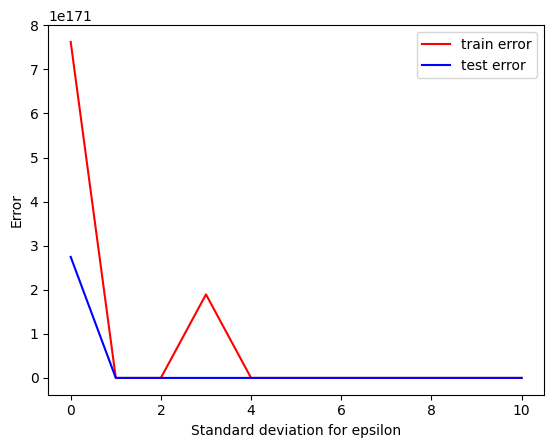

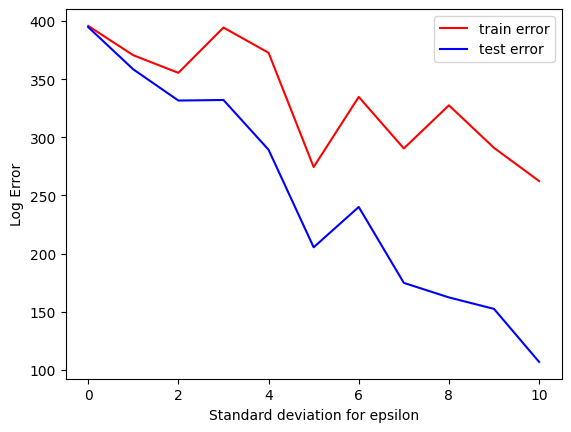

,StdDev,Training Error,Log Training Error,Test Error,Log Test Errors
0,0,7.623118e+171,395.773236,2.746017e+171,394.752203
1,1,8.695174e+160,370.576383,4.680593e+155,358.444114
2,2,2.316221e+154,355.438041,1.048838e+144,331.619936
3,3,1.894576e+171,394.381046,1.704801e+144,332.105702
4,4,7.161936e+161,372.684980,4.469141e+125,289.320333
5,5,1.551980e+119,274.447157,1.680036e+89,205.448889
6,6,2.418639e+145,334.758043,1.933028e+104,240.127937
7,7,1.375469e+126,290.444517,8.630717e+75,174.849210
8,8,1.744344e+142,327.523462,3.263351e+70,162.363711
9,9,2.251029e+126,290.937109,1.682492e+66,152.490892


In [129]:
epsilon_std = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
np.random.seed(760)

train_errors = []
test_errors = []
log_train_errors = []
log_test_errors = []

for std in epsilon_std:
    noise = np.random.normal(0, std, size=100)
    x_t = x_train + noise
    y_t = np.sin(x_t)

    p = lagrange(x_t, y_t)

    y_t_hat = np.polyval(p, x_t)
    y_test_hat = np.polyval(p, x_test)

    train_error = np.square(y_t_hat - y_t).mean()
    test_error = np.square(y_test_hat - y_test).mean()

    train_errors.append(train_error)
    test_errors.append(test_error)
    log_train_errors.append(math.log(train_error))
    log_test_errors.append(math.log(test_error))

# plot error vs std
plt.figure()
plt.plot(epsilon_std, train_errors, color="red", label="train error")
plt.plot(epsilon_std, test_errors, color="blue", label="test error")
plt.legend(loc="upper right")
plt.xlabel("Standard deviation for epsilon")
plt.ylabel("Error")
plt.show()
    

# Plot log error vs std
plt.figure()
plt.plot(epsilon_std, log_train_errors, color="red", label="train error")
plt.plot(epsilon_std, log_test_errors, color="blue", label="test error")
plt.legend(loc="upper right")
plt.xlabel("Standard deviation for epsilon")
plt.ylabel("Log Error")
plt.show()

metrics_s4 = pd.DataFrame({"StdDev": epsilon_std, "Training Error": train_errors, "Log Training Error": log_train_errors, "Test Error": test_errors, "Log Test Errors": log_test_errors})
metrics_s4

### Observation
The test error steadily decreases if we increase the margin of noise in our data. 
Also not that epsilon with zero standard deviation is acutally the data with no noise.